In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

In [33]:
def merge_tables(_pit: pd.DataFrame, _results: pd.DataFrame, _status: pd.DataFrame) -> pd.DataFrame:
    """
    merges the data files
    :param _pit:
    :param _results:
    :param _status:
    :return:
    """
    _select_col = ['raceId','driverId','positionOrder', 'laps', 'time','statusId']
    mg_df = pd.merge(_pit, _results[_select_col], on=['raceId','driverId'], how = 'left', suffixes=('_pit', '_result'))
    mg_df = pd.merge(mg_df, _status, on='statusId', how='left')

    _status_select = [1, 11, 12, 13, 14, 15, 16, 17, 18, 19]
    mg_df.drop(mg_df[~mg_df['statusId'].isin(_status_select)].index, inplace=True)
    return mg_df


def process_laps_stops(mg_df: pd.DataFrame) -> pd.DataFrame:
    _total_laps = mg_df[(mg_df['positionOrder'] == 1) & (mg_df['stop'] == 1)].reset_index(drop=True)[['raceId', 'laps']]
    _total_laps.columns = [str(_total_laps.columns[0]), 'total_laps']
    _total_stops = mg_df.groupby(by=['raceId', 'driverId'], as_index=False)['stop'].max()
    _total_stops.columns = list(_total_stops.columns[:2]) + ['total_stops']

    mg_df = pd.merge(mg_df, _total_laps, on='raceId')
    mg_df = pd.merge(mg_df, _total_stops, on=['raceId', 'driverId'])
    mg_df['lap_prop'] = mg_df.apply(lambda x: x['lap']/x['total_laps'], axis=1)

    return mg_df


def group_by_stop_num(df: pd.DataFrame) -> dict:
    pit_stop_max = df['total_stops'].max()
    _df_dict = {}
    for i in range(1, pit_stop_max+1):
        _df_dict[i] = df[df['total_stops']==i][['stop','lap_prop']]
    return _df_dict


def distribution_plot(_df_dict: dict, show_mean=True, show_description=True, save_fig=False):
    """
    d
    :param save_fig:
    :param show_description:
    :param show_mean:
    :param _df_dict:
    :return:
    """
    bins = np.linspace(0,1,50)
    color_bin = ['tab:blue', 'tab:orange', 'lightcoral']
    color_bin2 = ['deepskyblue', 'gold', 'crimson']
    max_num_of_stops = 3

    for ps_num in range(1, max_num_of_stops+1):
        plt.figure(figsize=(8,6))
        _df_tmp = _df_dict[ps_num]
        _df_list = [_df_tmp[_df_tmp['stop'] == i]['lap_prop'] for i in range(1, ps_num+1)]
        plot_count = 0
        if show_description: print('////////////////////////////////////////////////////////////////////////////////////////')
        print('Total Pit Stops: ', ps_num)
        for df in _df_list:
            plt.hist(df, bins, alpha=0.7, color=color_bin[plot_count])
            df_mean = round(df.mean(), ndigits=3)
            df_std = round(df.std(), ndigits=3)
            if show_mean: plt.axvline(x=df_mean, color=color_bin2[plot_count], linewidth=4)
            plot_count += 1
            if not show_description: continue
            print('No. ', plot_count, ' pit stop: ', 'mean = ', df_mean, ' std = ', df_std)
            perc_1 = len(df[(df <= df_mean + df_std) & (df >= df_mean - df_std)])/len(df)
            perc_2 = len(df[(df <= df_mean + 2*df_std) & (df >= df_mean - 2*df_std)])/len(df)
            perc_1 = round(100*perc_1, ndigits=1)
            perc_2 = round(100*perc_2, ndigits=1)
            print(f'    {perc_1}% within mean ± 1 std')
            print(f'    {perc_2}% within mean ± 2 std')
        if save_fig: plt.savefig(f'image/hypo2/distribution_{ps_num}.png')
        plt.show()

In [34]:
# Load data
pit = pd.read_csv('data/pit_stops.csv')
results = pd.read_csv('data/results.csv')
status = pd.read_csv('data/status.csv')

In [35]:
# Process the data files
merge_df = merge_tables(pit, results, status)
merge_df = process_laps_stops(merge_df)
df_dict = group_by_stop_num(merge_df)

In [36]:
# Plot distribution of Pit Stops, grouped by total number of pit stops
# distribution_plot(df_dict, show_mean=False, show_description=False)

////////////////////////////////////////////////////////////////////////////////////////
Total Pit Stops:  1
No.  1  pit stop:  mean =  0.416  std =  0.147
    66.9% within mean ± 1 std
    95.7% within mean ± 2 std


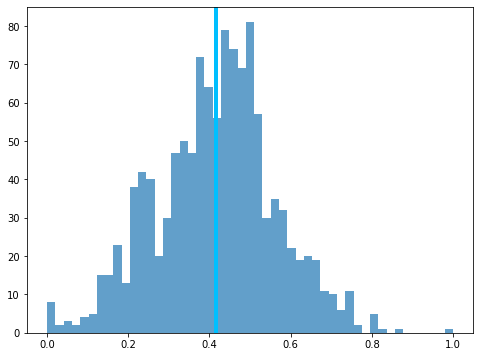

////////////////////////////////////////////////////////////////////////////////////////
Total Pit Stops:  2
No.  1  pit stop:  mean =  0.252  std =  0.118
    71.7% within mean ± 1 std
    95.8% within mean ± 2 std
No.  2  pit stop:  mean =  0.62  std =  0.134
    72.9% within mean ± 1 std
    93.1% within mean ± 2 std


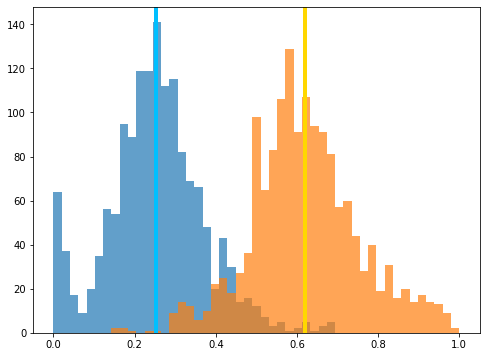

////////////////////////////////////////////////////////////////////////////////////////
Total Pit Stops:  3
No.  1  pit stop:  mean =  0.174  std =  0.098
    66.6% within mean ± 1 std
    97.5% within mean ± 2 std
No.  2  pit stop:  mean =  0.427  std =  0.155
    74.4% within mean ± 1 std
    92.6% within mean ± 2 std
No.  3  pit stop:  mean =  0.698  std =  0.13
    74.9% within mean ± 1 std
    93.9% within mean ± 2 std


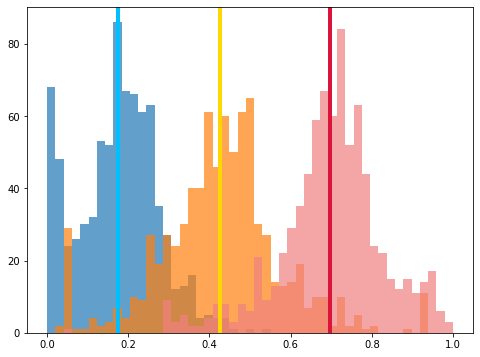

In [37]:
# Adding description for the distribution plot
distribution_plot(df_dict, save_fig=True)

In [38]:
# Run T Tests on the data group pairs
df_list = []
for ps_num in range(1,4):
    df_tmp = df_dict[ps_num]
    df_list += [df_tmp[df_tmp['stop'] == i]['lap_prop'] for i in range(1, ps_num+1)]

In [39]:
p2 = ttest_ind(df_list[1], df_list[2]).pvalue
print('2 pits, p value of T test:', p2, '< alpha = 0.05')

2 pits, p value of T test: 0.0 < alpha = 0.05


In [40]:
p3_1 = ttest_ind(df_list[3], df_list[4]).pvalue
p3_2 = ttest_ind(df_list[3], df_list[5]).pvalue
p3_3 = ttest_ind(df_list[4], df_list[5]).pvalue
print('3 pits, max p value of T test:', max(p3_1, p3_2, p3_3), '< alpha = 0.05')

3 pits, max p value of T test: 5.142138068782536e-225 < alpha = 0.05
